In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from tqdm.notebook import tqdm
tqdm.pandas()

import torch
import torchmetrics as tm
import seaborn as sns
from matplotlib import pyplot as plt
import re
import datetime

import warnings
warnings.filterwarnings("ignore")

In [3]:
SESSION_DIR_PATH = Path("../../session")
DATA_DIR_PATH = Path("../../data")
SESSION_DIR_PATH = Path("../../session")
TRAIN_DATASET_PATH = DATA_DIR_PATH.joinpath("jigsaw2019-train.csv")
TEST_DATASET_PATH = DATA_DIR_PATH.joinpath("jigsaw2019-test.csv")
LABEL_LIST = ['toxicity', 'obscene', 'sexual_explicit',
            'identity_attack', 'insult', 'threat']
IDENTITY_LIST = ['male', 'female', 'transgender', 'other_gender', 'heterosexual',
                'homosexual_gay_or_lesbian', 'bisexual','other_sexual_orientation',
                'christian', 'jewish', 'muslim', 'hindu','buddhist', 'atheist',
                'other_religion', 'black', 'white', 'asian', 'latino',
                'other_race_or_ethnicity', 'physical_disability',
                'intellectual_or_learning_disability',
                'psychiatric_or_mental_illness','other_disability']
SELECTED_IDENTITY_LIST = ['male', 'female', 'black', 'white', 'homosexual_gay_or_lesbian',
                    'christian', 'jewish', 'muslim', 'psychiatric_or_mental_illness']

SELECTED_SESSION_INFO = [('pierre-roberta-bce_2022-04-01T15-53-15-127273', 'BERT', 134088961, 0.153711),
                        ('pierre-roberta-pwbce_2022-04-01T00-16-50-635795', 'BERT', 134088961, 0.15284),
                        ('pierre-roberta-fl_2022-04-01T20-43-05-082657', 'BERT', 134088961, 0.154159),
                        ('pierre-roberta-pwfl_2022-04-01T20-44-35-459744', 'BERT', 134088961, 0.154602),
                        ('pierre-albert-pwbce_2022-04-02T08-52-15-316727', 'BERT', 21142278, 0.177142),
                        ('pierre-distilbert-pwbce_2022-04-02T08-51-40-340808', 'BERT', 75821574, 0.089415),
                        ('pierre-hatebert-pwbce_2022-04-02T14-16-41-524853', 'BERT', 118940934, 0.171139),
                        ('pierre-xlmroberta-pwbce_2022-04-02T14-48-21-276717', 'BERT', 287502342, 0.152607),
                        ('pierre-xlnet-pwbce_2022-04-02T18-31-29-083854', 'XLNet', 126177030, 0.242603),
                        ('pierre-bertweet-pwbce_2022-04-03T03-03-05-377047', 'BERT', 144358662, 0.1533),
                        ('pierre-unfreezed-glove-resnet44-pwbce_2022-04-03T03-07-30-490184', 'CNN', 26274138, 0.071897),
                        ('pierre-freezed-glove-resnet44-pwbce_2022-04-03T10-58-39-295726', 'CNN', 658038, 0.073078),
                        ('pierre-glove-bigru-pwbce_2022-04-03T18-21-04-474521', 'RNN', 27665706, 0.03195),
                        ('pierre-glove-bilstm-pwbce_2022-04-03T20-20-15-399610', 'RNN', 28348106, 0.034753),
                        ('glove-cct-pwbce_2022-04-03T22-49-02-960730', 'CCT', 62132971, 0.204585),
                        ('pierre-unfreezed-glove-resnet56-pwbce_2022-04-06T13-32-28-490973', 'CNN', 26468570, 0.08401)]

INDEX_RENAME = {
    "model_type":"Model type",
    "id":"Id",
    "session_name":"Model name"
}

SESSION_RENAME = {
    "roberta-bce":"RoBERTa BCE",
    "roberta-pwbce":"RoBERTa pwBCE",
    "roberta-fl":"RoBERTa FL",
    "roberta-pwfl":"RoBERTa pwFL",
    "albert-pwbce":"AlBERT",
    "distilbert-pwbce":"DistilBERT",
    "hatebert-pwbce":"HateBERT",
    "xlmroberta-pwbce":"XLM RoBERTa",
    "xlnet-pwbce":"XLNet",
    "bertweet-pwbce":"BERTweet",
    "unfreezed-glove-resnet44-pwbce":"Unfreeze GloVe ResNet44",
    "freezed-glove-resnet44-pwbce":"Freeze GloVe ResNet44",
    "glove-bigru-pwbce":"BiGRU",
    "glove-bilstm-pwbce":"BiLSTM",
    "glove-cct-pwbce":"CCT",
    "unfreezed-glove-resnet56-pwbce":"Unfreeze GloVe ResNet56"
}

SELECTED_SESSION_NAME = [name for name, _,  _, _ in SELECTED_SESSION_INFO]
SELECTED_SESSION_PARAMS = [params for _, _, params, _ in SELECTED_SESSION_INFO]
SELECTED_SESSION_BATCHTIME = [batchtime for _, _, _, batchtime in SELECTED_SESSION_INFO]

In [4]:
validation_dataset_namespace = lambda session_name: f"{session_name}.jigsaw2019-validation.csv"
log_namespace = lambda session_name: f"{session_name}.loguru.log"
metric_namespace = lambda session_name: f"{session_name}.metric.json"
test_prediction_namespace = lambda session_name: f"{session_name}.test.csv"
validation_prediction_namespace = lambda session_name: f"{session_name}.validation.csv"

## Metrics en général

In [5]:
# Adapted from : https://gist.github.com/aditya-5842/b2a886f42bc9988dc11c1737a349830c

from sklearn.metrics import roc_auc_score

########################################################################################
#######################     function to calculate the AUC        #######################
########################################################################################

def cal_auc(y_true, y_pred):
    "returns the auc value"
    return roc_auc_score(y_true, y_pred)

########################################################################################
#######################  function to calculate the Subgroup AUC  #######################
########################################################################################

def cal_subgroup_auc(target_df, prediction_df, subgroups, label):
    subgroup_filter = target_df[subgroups] == 1
    return cal_auc(target_df[subgroup_filter][label], prediction_df[subgroup_filter][label])

########################################################################################
#######################   function to calculate the BPSN AUC     #######################
########################################################################################

def cal_bpsn_auc(target_df, prediction_df, subgroups, label):
    """This will calculate the BPSN auc"""
    subgroup_filter = target_df[subgroups] == 1
    positive_label_filter = target_df[label] == 1
    # subset where subgroup is True and target label is 0
    pred_subgroup_negative_examples = prediction_df[subgroup_filter & ~positive_label_filter]
    target_subgroup_negative_examples = target_df[subgroup_filter & ~positive_label_filter]

    # subset where subgroup is False and target label is 1
    pred_background_positive_examples = prediction_df[~subgroup_filter & positive_label_filter]
    target_background_positive_examples = target_df[~subgroup_filter & positive_label_filter]

    # combine above two sets
    pred_bpsn_examples = pd.concat([pred_subgroup_negative_examples, pred_background_positive_examples])
    target_bpsn_examples = pd.concat([target_subgroup_negative_examples, target_background_positive_examples])

    return cal_auc(target_bpsn_examples[label], pred_bpsn_examples[label])


########################################################################################
#######################   function to calculate the BNSP AUC     #######################
########################################################################################
def cal_bnsp_auc(target_df, prediction_df, subgroups, label):
    """This will calculate the BNSP auc"""
    subgroup_filter = target_df[subgroups] == 1
    positive_label_filter = target_df[label] == 1

    # subset where subgroup is True and target label is 1
    pred_subgroup_positive_examples = prediction_df[subgroup_filter & positive_label_filter]
    target_subgroup_positive_examples = target_df[subgroup_filter & positive_label_filter]

    # subset where subgroup is False and target label is 0
    pred_background_negative_examples = prediction_df[~subgroup_filter & ~positive_label_filter]
    target_background_negative_examples = target_df[~subgroup_filter & ~positive_label_filter]

    # combine above two sets
    pred_bnsp_examples = pd.concat([pred_subgroup_positive_examples, pred_background_negative_examples])
    target_bnsp_examples = pd.concat([target_subgroup_positive_examples, target_background_negative_examples])

    return cal_auc(target_bnsp_examples[label], pred_bnsp_examples[label])

########################################################################################
#######################    function to calculate Bias metric     #######################
########################################################################################
def cal_bias_metric(target_df, prediction_df, subgroups, label):
    """Computes per-subgroup metrics for all subgroups and one model
    and returns the dataframe which will have all three Bias metrices
    and number of exmaples for each subgroup"""
    records = []
    for subgroup in subgroups:
        record = {"subgroup": subgroup, "subgroup_size": len(target_df[target_df[subgroup] == 1])}
        record["subgroup_auc"] = cal_subgroup_auc(target_df, prediction_df, subgroup, label)
        record["bpsn_auc"]     = cal_bpsn_auc(target_df, prediction_df, subgroup, label)
        record["bnsp_auc"]     = cal_bnsp_auc(target_df, prediction_df, subgroup, label)

        records.append(record)
    submetric_df = pd.DataFrame(records)

    return submetric_df

########################################################################################
#######################   function to calculate Overall metric   #######################
########################################################################################
def cal_overall_auc(target_df, prediction_df, label):
    return roc_auc_score(target_df[label], prediction_df[label])

########################################################################################
#######################    function to calculate final metric    #######################
########################################################################################
def power_mean(series, p):
    total_sum = np.sum(np.power(series, p))
    return np.power(total_sum/len(series), 1/p)

def final_metric(submetric_df, overall_auc, p = -5, w = 0.25):
    generalized_subgroup_auc = power_mean(submetric_df["subgroup_auc"], p)
    generalized_bpsn_auc = power_mean(submetric_df["bpsn_auc"], p)
    generalized_bnsp_auc = power_mean(submetric_df["bnsp_auc"], p)
    
    overall_metric = w*overall_auc + w*(generalized_subgroup_auc
                                        + generalized_bpsn_auc
                                        + generalized_bnsp_auc)
    return overall_metric

def generalized_auc_metric(target_df, prediction_df, subgroups, label, p = -5):
    submetric_df = cal_bias_metric(target_df, prediction_df, subgroups, label)
    
    generalized_subgroup_auc = power_mean(submetric_df["subgroup_auc"], p)
    generalized_bpsn_auc = power_mean(submetric_df["bpsn_auc"], p)
    generalized_bnsp_auc = power_mean(submetric_df["bnsp_auc"], p)

    return dict(generalized_subgroup_auc=generalized_subgroup_auc, 
                generalized_bpsn_auc=generalized_bpsn_auc,
                generalized_bnsp_auc=generalized_bnsp_auc)

########################################################################################
#######################   function all above function into one   #######################
########################################################################################

def return_final_metric(target_df, prediction_df, subgroups, label):
    """Data is dataframe which include whole data 
    and it also has the predicted target column"""
    submetric_df = cal_bias_metric(target_df, prediction_df, subgroups, label)

    overall_auc =  cal_overall_auc(target_df, prediction_df, label)
    overall_metric = final_metric(submetric_df, overall_auc, p = -5, w = 0.25)

    return overall_metric, submetric_df

## Preparer les données

In [6]:
target_test_df = pd.read_csv(TEST_DATASET_PATH, index_col=0)
#target_test_df = target_test_df[~target_test_df.white.isna()]# TO REMOVE
target_test_df[LABEL_LIST] = (target_test_df[LABEL_LIST] >= 0.5).astype(int)
#target_test_df.reset_index(inplace=True)

In [7]:
identity_target_test_df = target_test_df.copy()
identity_target_test_df[LABEL_LIST + IDENTITY_LIST] = (identity_target_test_df[LABEL_LIST + IDENTITY_LIST] >= 0.5).astype(int)
identity_target_test_df.reset_index(inplace=True)

## Fonction à appliquer pour chaque model

### Générique

In [8]:
def get_best_f1_threshold(session_name):
    # # Path
    # session_path = SESSION_DIR_PATH.joinpath(session_name)
    # validation_target_path = session_path.joinpath(validation_dataset_namespace(session_name))
    # validation_prediction_path = session_path.joinpath(validation_prediction_namespace(session_name))

    # # Read files
    # target_validation_df = pd.read_csv(validation_target_path, index_col=0)
    # pred_validation_df = pd.read_csv(validation_prediction_path, index_col=0)

    # # Clean data
    # pred_validation_df = pred_validation_df[LABEL_LIST]
    # target_validation_df = (target_validation_df[LABEL_LIST] >= 0.5).astype(int)

    # # Create tensors
    # target_tensor = torch.Tensor(target_validation_df.to_numpy()).to(int)
    # prediction_tensor = torch.Tensor(pred_validation_df.to_numpy())

    # thresholds = np.arange(0, 1, 0.001)
    # scores = [tm.F1Score(threshold=t, average="micro")(prediction_tensor, target_tensor) for t in tqdm(thresholds, leave=False)]
    # # get best threshold
    # ix = np.argmax(scores)
    # best_thresholds = thresholds[ix]
    # TODO FIXEME : Ajouter un jeu de validation/prediction sur ce jeu pour chaque session
    return 0.8

### Groupe By

In [9]:
def perf_and_bias_metric_per_model(prediction_test_df : pd.DataFrame):
    result_metric_dict = dict()

    # Performance
    perf_metric_dict = dict()
    ## AUROC Macro
    perf_metric_dict["auroc_macro"] = tm.AUROC(num_classes=len(LABEL_LIST), average="macro")
    ## F1 Score Macro
    perf_metric_dict["f1_macro_50"] = tm.F1Score(num_classes=len(LABEL_LIST), average="macro", threshold=0.5)
    ## F1 Score Micro
    perf_metric_dict["f1_micro_50"] = tm.F1Score(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)
    ## Micro F1@BestTh
    # session_name = prediction_test_df["session_name"].to_list()[0]
    # best_threshold = get_best_f1_threshold(session_name)
    # perf_metric_dict["best_f1_micro"] = tm.F1Score(num_classes=len(LABEL_LIST), average="micro", threshold=best_threshold)
    
    ## Recall
    perf_metric_dict["recall_micro_50"] = tm.Recall(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)
    ## Precision
    perf_metric_dict["precision_micro_50"] = tm.Precision(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)

    perf_metric_collection = tm.MetricCollection(perf_metric_dict)

    pred_tensor = torch.Tensor(prediction_test_df[LABEL_LIST].to_numpy())
    target_tensor = torch.Tensor(target_test_df[LABEL_LIST].to_numpy()).to(int)
    perf_result_metric_dict = perf_metric_collection(pred_tensor, target_tensor)
    perf_result_metric_dict = {key:value.item() for key, value in perf_result_metric_dict.items()}
    result_metric_dict.update(perf_result_metric_dict)

    # Biais
    label = "toxicity"
    # Add identity label to prediction DataFrame
    identity_prediction_test_df = pd.concat([prediction_test_df, identity_target_test_df[IDENTITY_LIST]], axis=1)

    # Remove NaN value identity label sample
    identity_prediction_test_df = identity_prediction_test_df[~identity_prediction_test_df.white.isna()]
    result_metric_dict.update(generalized_auc_metric(identity_target_test_df, identity_prediction_test_df, SELECTED_IDENTITY_LIST, label))

    return pd.Series(result_metric_dict)

In [10]:
def identity_aur_per_sub_per_model(prediction_test_df):
    label = "toxicity"
    # Add identity label to prediction DataFrame
    identity_prediction_test_df = pd.concat([prediction_test_df, identity_target_test_df[IDENTITY_LIST]], axis=1)
    # Remove NaN value identity label sample
    identity_prediction_test_df = identity_prediction_test_df[~identity_prediction_test_df.white.isna()]
    return cal_bias_metric(identity_target_test_df[~identity_target_test_df.white.isna()], identity_prediction_test_df, SELECTED_IDENTITY_LIST, label)

In [11]:
def metric_per_class_per_model(prediction_test_df):
    f1_50_per_class = tm.AUROC(num_classes=len(LABEL_LIST), average=None)

    pred_tensor = torch.Tensor(prediction_test_df[LABEL_LIST].to_numpy())
    target_tensor = torch.Tensor(target_test_df[LABEL_LIST].to_numpy()).to(int)

    perf_metric = f1_50_per_class(pred_tensor, target_tensor)
    return pd.Series(perf_metric, index=LABEL_LIST)

## Calcul sur les sessions

In [12]:
prediction_test_df = None
for session_name in tqdm(SELECTED_SESSION_NAME):
    session_path = SESSION_DIR_PATH.joinpath(session_name)
    test_file_path =session_path.joinpath(test_prediction_namespace(session_name))
    current_test_df = pd.read_csv(test_file_path, index_col=0)
    current_test_df["session_name"] = session_name
    if prediction_test_df is None:
        prediction_test_df = current_test_df
    else:
        prediction_test_df = pd.concat([prediction_test_df, current_test_df])


  0%|          | 0/16 [00:00<?, ?it/s]

In [13]:
groupby_test_df = prediction_test_df.groupby("session_name")

In [14]:
def add_model_type(data_df : pd.DataFrame) -> pd.DataFrame:
    model_type_dict = {session_name:model_type for session_name, model_type, _, _ in SELECTED_SESSION_INFO}
    data_df["model_type"] = data_df.apply(lambda row: model_type_dict[row.session_name], axis=1)
    return data_df

### Perf & Biais Metric pour chaque Model

In [15]:
multi_metric_per_model_df = groupby_test_df.progress_apply(perf_and_bias_metric_per_model)

  0%|          | 0/16 [00:00<?, ?it/s]

In [16]:
# Remove session_name as index
multi_metric_per_model_df.reset_index(inplace=True)
multi_metric_per_model_df = add_model_type(multi_metric_per_model_df)
multi_metric_per_model_df = multi_metric_per_model_df.sort_values(["model_type", "session_name"]).reset_index(drop=True)

# Rename index to "id"
multi_metric_per_model_df.index.rename("id", inplace=True)

In [17]:
# PERF & PARAMS GRAPH
perf_and_params_per_model_df = multi_metric_per_model_df.copy()

# PERF & BIAS TAB
perf_and_bias_metric_per_model_df = multi_metric_per_model_df.copy()

In [18]:
# The id is used to identify easily the model instead of using a long session name
perf_and_bias_metric_per_model_df["session_name"] = perf_and_bias_metric_per_model_df["session_name"].apply(lambda session_name: session_name.split("_")[0])
perf_and_bias_metric_per_model_df["session_name"] = perf_and_bias_metric_per_model_df["session_name"].apply(lambda session_name: session_name[7:] if session_name.startswith("pierre-") else session_name)

# Add multi index with id and session_name
perf_and_bias_metric_per_model_df.set_index(["model_type", perf_and_bias_metric_per_model_df.index, "session_name"], inplace=True)

In [19]:
perf_and_bias_metric_per_model_df

auroc_macro  f1_macro_50  \
model_type id session_name                                               
BERT       0  albert-pwbce                       0.978966     0.346320   
           1  bertweet-pwbce                     0.981561     0.361618   
           2  distilbert-pwbce                   0.980360     0.387945   
           3  hatebert-pwbce                     0.979072     0.367850   
           4  roberta-bce                        0.981323     0.474881   
           5  roberta-fl                         0.981787     0.464816   
           6  roberta-pwbce                      0.980888     0.354077   
           7  roberta-pwfl                       0.980938     0.361202   
           8  xlmroberta-pwbce                   0.979014     0.336809   
CCT        9  glove-cct-pwbce                    0.950467     0.342845   
CNN        10 freezed-glove-resnet44-pwbce       0.952641     0.418899   
           11 unfreezed-glove-resnet44-pwbce     0.965968     0.456557   
           12 unfreezed-glove-resnet56-pwbce     0.963870     0.377804   
RNN        13 glove-bigru-pwbce                  0.974819     0.349250   
           14 glove-bilstm-pwbce                 0.975391     0.363805   
XLNet      15 xlnet-pwbce                        0.979971     0.333617   

                                              f1_micro_50  precision_micro_50  \
model_type id session_name                                                      
BERT       0  albert-pwbce                       0.478641            0.324673   
           1  bertweet-pwbce                     0.492812            0.336333   
           2  distilbert-pwbce                   0.511465            0.357228   
           3  hatebert-pwbce                     0.484449            0.329246   
           4  roberta-bce                        0.535949            0.383589   
           5  roberta-fl                         0.552381            0.401704   
           6  roberta-pwbce                      0.484458            0.328398   
           7  roberta-pwfl                       0.486145            0.329668   
           8  xlmroberta-pwbce                   0.468018            0.313493   
CCT        9  glove-cct-pwbce                    0.487355            0.350741   
CNN        10 freezed-glove-resnet44-pwbce       0.559082            0.463091   
           11 unfreezed-glove-resnet44-pwbce     0.595780            0.483515   
           12 unfreezed-glove-resnet56-pwbce     0.509798            0.360408   
RNN        13 glove-bigru-pwbce                  0.476162            0.323249   
           14 glove-bilstm-pwbce                 0.508891            0.358587   
XLNet      15 xlnet-pwbce                        0.458573            0.304453   

                                              recall_micro_50  \
model_type id session_name                                      
BERT       0  albert-pwbce                           0.910351   
           1  bertweet-pwbce                         0.921574   
           2  distilbert-pwbce                       0.900086   
           3  hatebert-pwbce                         0.916458   
           4  roberta-bce                            0.889094   
           5  roberta-fl                             0.883945   
           6  roberta-pwbce                          0.923158   
           7  roberta-pwfl                           0.925370   
           8  xlmroberta-pwbce                       0.922960   
CCT        9  glove-cct-pwbce                        0.798290   
CNN        10 freezed-glove-resnet44-pwbce           0.705275   
           11 unfreezed-glove-resnet44-pwbce         0.775944   
           12 unfreezed-glove-resnet56-pwbce         0.870709   
RNN        13 glove-bigru-pwbce                      0.903618   
           14 glove-bilstm-pwbce                     0.876122   
XLNet      15 xlnet-pwbce                            0.928703   

                                              generalized_subgroup_auc  \
model_typ

#### Tableau des metriques en fonction des modèles

##### Renommer `session_name` et les colonnes

In [20]:
rename_map = {
    "auroc_macro": "AUROC",
    #"best_f1_micro": "F1@B",
    "f1_macro_50": "Macro F1",
    "f1_micro_50": "Micro F1",
    "precision_micro_50": "Precision",
    "recall_micro_50": "Recall",
    "generalized_subgroup_auc": "GMB Sub.",
    "generalized_bpsn_auc": "GMB BPSN",
    "generalized_bnsp_auc": "GMB BNSP",
}
perf_and_bias_metric_per_model_df.rename(rename_map, inplace=True)

In [21]:
multi_columns = [('Performance', 'AUROC'),
                #('Performance', 'F1@B'),
                ('Performance', 'Macro F1'),
                ('Performance', 'Micro F1'),
                ('Performance', 'Precision'),
                ('Performance', 'Recall'),
                ('Bias', 'GMB Sub.'),
                ('Bias', 'GMB BPSN'),
                ('Bias', 'GMB BNSP')]

perf_and_bias_metric_per_model_df.columns = pd.MultiIndex.from_tuples(multi_columns)

In [22]:
perf_and_bias_metric_per_model_df.rename(index=SESSION_RENAME, inplace=True)
perf_and_bias_metric_per_model_df.index.rename(INDEX_RENAME, inplace=True)
perf_and_bias_metric_per_model_df

Performance                      \
                                            AUROC  Macro F1  Micro F1   
Model type Id Model name                                                
BERT       0  AlBERT                     0.978966  0.346320  0.478641   
           1  BERTweet                   0.981561  0.361618  0.492812   
           2  DistilBERT                 0.980360  0.387945  0.511465   
           3  HateBERT                   0.979072  0.367850  0.484449   
           4  RoBERTa BCE                0.981323  0.474881  0.535949   
           5  RoBERTa FL                 0.981787  0.464816  0.552381   
           6  RoBERTa pwBCE              0.980888  0.354077  0.484458   
           7  RoBERTa pwFL               0.980938  0.361202  0.486145   
           8  XLM RoBERTa                0.979014  0.336809  0.468018   
CCT        9  CCT                        0.950467  0.342845  0.487355   
CNN        10 Freeze GloVe ResNet44      0.952641  0.418899  0.559082   
           11 Unfreeze GloVe ResNet44    0.965968  0.456557  0.595780   
           12 Unfreeze GloVe ResNet56    0.963870  0.377804  0.509798   
RNN        13 BiGRU                      0.974819  0.349250  0.476162   
           14 BiLSTM                     0.975391  0.363805  0.508891   
XLNet      15 XLNet                      0.979971  0.333617  0.458573   

                                                               Bias            \
                                      Precision    Recall  GMB Sub.  GMB BPSN   
Model type Id Model name                                                        
BERT       0  AlBERT                   0.324673  0.910351  0.867430  0.899828   
           1  BERTweet                 0.336333  0.921574  0.878005  0.894502   
           2  DistilBERT               0.357228  0.900086  0.876181  0.874003   
           3  HateBERT                 0.329246  0.916458  0.874366  0.891479   
           4  RoBERTa BCE              0.383589  0.889094  0.880017  0.890083   
           5  RoBERTa FL               0.401704  0.883945  0.880695  0.900957   
           6  RoBERTa pwBCE            0.328398  0.923158  0.874105  0.898197   
           7  RoBERTa pwFL             0.329668  0.925370  0.873434  0.891970   
           8  XLM RoBERTa              0.313493  0.922960  0.868879  0.885950   
CCT        9  CCT                      0.350741  0.798290  0.813281  0.830681   
CNN        10 Freeze GloVe ResNet44    0.463091  0.705275  0.821923  0.787577   
           11 Unfreeze GloVe ResNet44  0.483515  0.775944  0.842061  0.849257   
           12 Unfreeze GloVe ResNet56  0.360408  0.870709  0.848731  0.844451   
RNN        13 BiGRU                    0.323249  0.903618  0.857258  0.861632   
           14 BiLSTM                   0.358587  0.876122  0.863563  0.875760   
XLNet      15 XLNet                    0.304453  0.928703  0.873850  0.883361   

                                                 
                                       GMB BNSP  
Model type Id Model name                         
BERT       0  AlBERT                   0.951305  
           1  BERTweet                 0.960273  
           2  DistilBERT               0.964442  
           3  HateBERT                 0.958937  
           4  RoBERTa BCE              0.961594  
           5  RoBERTa FL               0.959741  
           6  RoBERTa pwBCE            0.957460  
           7  RoBERTa pwFL             0.959730  
           8  XLM RoBERTa              0.958124  
CCT        9  CCT                      0.944716  
CNN        10 Freeze GloVe ResNet44    0.949929  
           11 Unfreeze GloVe ResNet44  0.954003  
           12 Unfreeze GloVe ResNet56  0.957860  
RNN        13 BiGRU                    0.960043  
           14 BiLSTM                   0.956948  
XLNet      15 XLNet                    0.959699

##### Style

In [23]:
def bold_max_value(column):
    is_max_list = column == column.max()
    return ["font-weight: bold" if is_max else "" for is_max in is_max_list]

In [24]:
perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_df.style.background_gradient(axis=0, cmap="PuBu_r")
perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_style.format(precision=4)
perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_style.apply(bold_max_value)

#perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_style.applymap_index(lambda v: "rotatebox:{45}--rwrap--latex;", axis=1)

perf_and_bias_metric_per_model_style

In [25]:
perf_and_bias_metric_per_model_latex = perf_and_bias_metric_per_model_style.to_latex(
    convert_css=True,
    column_format="lllllllllll",
    clines="all;data",
    multicol_align="c",
    hrules=True,
)
print(perf_and_bias_metric_per_model_latex)

\begin{tabular}{lllllllllll}
\toprule
 &  &  & \multicolumn{5}{c}{Performance} & \multicolumn{3}{c}{Bias} \\
 &  &  & AUROC & Macro F1 & Micro F1 & Precision & Recall & GMB Sub. & GMB BPSN & GMB BNSP \\
Model type & Id & Model name &  &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{9}{*}{BERT} & 0 & AlBERT & {\cellcolor[HTML]{F1EBF5}} \color[HTML]{000000} 0.9790 & {\cellcolor[HTML]{03517E}} \color[HTML]{F1F1F1} 0.3463 & {\cellcolor[HTML]{045E93}} \color[HTML]{F1F1F1} 0.4786 & {\cellcolor[HTML]{045687}} \color[HTML]{F1F1F1} 0.3247 & {\cellcolor[HTML]{F2ECF5}} \color[HTML]{000000} 0.9104 & {\cellcolor[HTML]{DCDAEB}} \color[HTML]{000000} 0.8674 & {\cellcolor[HTML]{FEF6FA}} \color[HTML]{000000} 0.8998 & {\cellcolor[HTML]{2685BB}} \color[HTML]{F1F1F1} 0.9513 \\
\cline{2-11} \cline{3-11}
 & 1 & BERTweet & {\cellcolor[HTML]{FEF6FB}} \color[HTML]{000000} 0.9816 & {\cellcolor[HTML]{0567A1}} \color[HTML]{F1F1F1} 0.3616 & {\cellcolor[HTML]{056FAF}} \color[HTML]{F1F1F1} 0.4928 & {\cellcolor[HTML]{04

##### Bon exemple d'importation dans LaTeX

* Retirer les `\cline{2-11} \cline{3-11}`
* Ajouter ` \cmidrule(lr){4-8} \cmidrule(lr){9-11}`

Il faut encadrer ce code par :
```latex
\usepackage{booktabs}
\usepackage[table]{xcolor}
\usepackage{graphicx}

\begin{table*}[htb!]
\resizebox{1.0\linewidth}{!}{
%%%

% Write HERE

%%%
}
\caption{Model performance results}
\label{tab:results}
\end{table*}
```

```latex
\begin{table*}[htb!]
\resizebox{1.0\linewidth}{!}{
%%%
\begin{tabular}{llllllllll}
\toprule
 &  & \multicolumn{5}{c }{Performance} & \multicolumn{3}{c}{Bias} \\
\cmidrule(lr){3-7}
\cmidrule(lr){8-10}
 &  & AUROC & Macro F1 & Micro F1 & Precision & Recall & GMB Sub. & GMB BPSN & GMB BNSP \\
Id & Model &  &  &  &  &  &  &  &  \\
\midrule

....

\bottomrule
\end{tabular}
%%%
}
\caption{Model performance results}
\label{tab:results}
\end{table*}
```

#### Performance en fonction du temps par batch et de la taille du modèle

In [26]:
params_dict = {session_name:params for session_name, _, params, _ in SELECTED_SESSION_INFO}
batchtime_dict = {session_name:batchtime for session_name, _, _, batchtime in SELECTED_SESSION_INFO}

clean_perf_and_params_per_model_df = perf_and_params_per_model_df.copy()

clean_perf_and_params_per_model_df["parameters"] = perf_and_params_per_model_df.apply(lambda row: params_dict[row.session_name], axis=1)
clean_perf_and_params_per_model_df["batch_time"] = perf_and_params_per_model_df.apply(lambda row: batchtime_dict[row.session_name], axis=1)

clean_perf_and_params_per_model_df.session_name = perf_and_params_per_model_df.session_name.apply(lambda session_name: session_name.split("_")[0])
clean_perf_and_params_per_model_df.session_name = clean_perf_and_params_per_model_df.session_name.apply(lambda session_name: session_name[7:] if session_name.startswith("pierre-") else session_name)

In [27]:
clean_perf_and_params_per_model_df

,session_name,auroc_macro,f1_macro_50,f1_micro_50,precision_micro_50,recall_micro_50,generalized_subgroup_auc,generalized_bpsn_auc,generalized_bnsp_auc,model_type,parameters,batch_time
id,,,,,,,,,,,,
0,albert-pwbce,0.978966,0.346320,0.478641,0.324673,0.910351,0.867430,0.899828,0.951305,BERT,21142278,0.177142
1,bertweet-pwbce,0.981561,0.361618,0.492812,0.336333,0.921574,0.878005,0.894502,0.960273,BERT,144358662,0.153300
2,distilbert-pwbce,0.980360,0.387945,0.511465,0.357228,0.900086,0.876181,0.874003,0.964442,BERT,75821574,0.089415
3,hatebert-pwbce,0.979072,0.367850,0.484449,0.329246,0.916458,0.874366,0.891479,0.958937,BERT,118940934,0.171139
4,roberta-bce,0.981323,0.474881,0.535949,0.383589,0.889094,0.880017,0.890083,0.961594,BERT,134088961,0.153711
5,roberta-fl,0.981787,0.464816,0.552381,0.401704,0.883945,0.880695,0.900957,0.959741,BERT,134088961,0.154159
6,roberta-pwbce,0.980888,0.354077,0.484458,0.328398,0.923158,0.874105,0.898197,0.957460,BERT,134088961,0.152840
7,roberta-pwfl,0.980938,0.361202,0.486145,0.329668,0.925370,0.873434,0.891970,0.959730,BERT,134088961,0.154602
8,xlmroberta-pwbce,0.979014,0.336809,0.468018,0.313493,0.922960,0.868879,0.885950,0.958124,BERT,287502342,0.152607


In [28]:
excluded_session_name_list = ["roberta-bce", "roberta-fl", "roberta-pwfl"]

In [29]:
clean_perf_and_params_per_model_df = clean_perf_and_params_per_model_df[clean_perf_and_params_per_model_df.apply(lambda r: r.session_name not in excluded_session_name_list, axis=1)]

In [30]:
clean_perf_and_params_per_model_df

,session_name,auroc_macro,f1_macro_50,f1_micro_50,precision_micro_50,recall_micro_50,generalized_subgroup_auc,generalized_bpsn_auc,generalized_bnsp_auc,model_type,parameters,batch_time
id,,,,,,,,,,,,
0,albert-pwbce,0.978966,0.346320,0.478641,0.324673,0.910351,0.867430,0.899828,0.951305,BERT,21142278,0.177142
1,bertweet-pwbce,0.981561,0.361618,0.492812,0.336333,0.921574,0.878005,0.894502,0.960273,BERT,144358662,0.153300
2,distilbert-pwbce,0.980360,0.387945,0.511465,0.357228,0.900086,0.876181,0.874003,0.964442,BERT,75821574,0.089415
3,hatebert-pwbce,0.979072,0.367850,0.484449,0.329246,0.916458,0.874366,0.891479,0.958937,BERT,118940934,0.171139
6,roberta-pwbce,0.980888,0.354077,0.484458,0.328398,0.923158,0.874105,0.898197,0.957460,BERT,134088961,0.152840
8,xlmroberta-pwbce,0.979014,0.336809,0.468018,0.313493,0.922960,0.868879,0.885950,0.958124,BERT,287502342,0.152607
9,glove-cct-pwbce,0.950467,0.342845,0.487355,0.350741,0.798290,0.813281,0.830681,0.944716,CCT,62132971,0.204585
10,freezed-glove-resnet44-pwbce,0.952641,0.418899,0.559082,0.463091,0.705275,0.821923,0.787577,0.949929,CNN,658038,0.073078
11,unfreezed-glove-resnet44-pwbce,0.965968,0.456557,0.595780,0.483515,0.775944,0.842061,0.849257,0.954003,CNN,26274138,0.071897


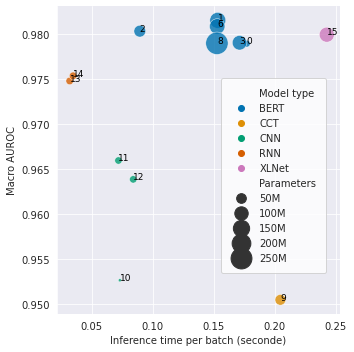

In [31]:
rename_label_dict = {
    "model_type":"Model type",
    "parameters":"Parameters",
    "0.5":"50M",
    "1.0":"100M",
    "1.5":"150M",
    "2.0":"200M",
    "2.5":"250M",
}

sns.set_style("darkgrid")

g = sns.relplot(
    data=clean_perf_and_params_per_model_df,
    x="batch_time", y="auroc_macro",
    size="parameters",
    hue="model_type", sizes=(10, 500),
    alpha=0.8,
    palette="colorblind",
)

for t in g._legend.texts:
    t.set_text(rename_label_dict.get(t.get_text(), t.get_text()))

g.ax.xaxis.grid(True)
g.ax.yaxis.grid(True)
plt.xlabel("Inference time per batch (seconde)")
plt.ylabel("Macro AUROC")

for k, v in clean_perf_and_params_per_model_df.iterrows():
    g.ax.annotate(k, (v.batch_time, v.auroc_macro),
                xytext=(0,0), textcoords='offset points',
                family='sans-serif', fontsize=9, color='black')


#sns.move_legend(g, "lower center", ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.3))
sns.move_legend(g, "center right", ncol=1, frameon=True, bbox_to_anchor=(0.8, 0.5), borderpad=1)

legend = g._legend
frame = legend.get_frame()
frame.set_facecolor('white')

plt.savefig('perf_and_params_per_model_df.pdf', bbox_inches='tight')
plt.show()

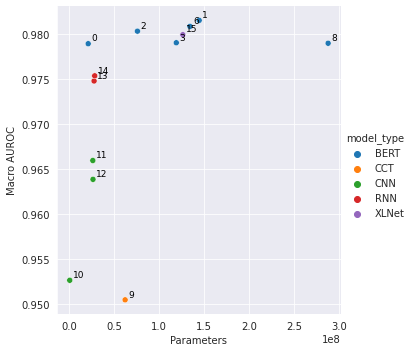

In [32]:
rename_label_dict = {
    "model_type":"Model type",
    "parameters":"Parameters",
    "0.5":"50M",
    "1.0":"100M",
    "1.5":"150M",
    "2.0":"200M",
    "2.5":"250M",
}

sns.set_style("darkgrid")


g = sns.relplot(
    data=clean_perf_and_params_per_model_df,
    x="parameters", y="auroc_macro",
    hue="model_type", sizes=(10, 500),
    alpha=1,
)

for t in g._legend.texts:
    t.set_text(rename_label_dict.get(t.get_text(), t.get_text()))
#g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True)
g.ax.yaxis.grid(True)
plt.xlabel("Parameters")
plt.ylabel("Macro AUROC")

#for i in range(perf_and_params_per_model_df.shape[0]):
#    g.ax.text(perf_and_params_per_model_df.batch_time[i] + 2, perf_and_params_per_model_df.auroc_macro[i] + 0.005, perf_and_params_per_model_df.index[i], horizontalalignment='center', size='medium', color='black', weight='semibold')

for k, v in clean_perf_and_params_per_model_df.iterrows():
    g.ax.annotate(k, (v.parameters, v.auroc_macro),
                xytext=(3,3), textcoords='offset points',
                family='sans-serif', fontsize=9, color='black')

#g.ax.annotate(, (2,0.960))
plt.savefig('perf_and_only_params_per_model_df.svg')
plt.show()

In [33]:
with open("number_model_map.log", "w") as f:
    f.write("\n".join([f"{i}. {name}" for i, name in enumerate(perf_and_params_per_model_df.session_name.to_list())]))

### Histograme AUC par modèle et par identité

In [34]:
model_type_dict = {session_name:model_type for session_name, model_type, _, _ in SELECTED_SESSION_INFO}

identity_aur_per_sub_per_model_df = groupby_test_df.progress_apply(identity_aur_per_sub_per_model)

identity_aur_per_sub_per_model_df.reset_index(inplace=True)
identity_aur_per_sub_per_model_df = identity_aur_per_sub_per_model_df.melt(id_vars=["session_name", "subgroup"], value_vars=["subgroup_auc", "bpsn_auc", "bnsp_auc"])
identity_aur_per_sub_per_model_df["model_type"] = identity_aur_per_sub_per_model_df.apply(lambda row: model_type_dict[row.session_name], axis=1)

  0%|          | 0/16 [00:00<?, ?it/s]

In [35]:
identity_aur_per_sub_per_model_df

,session_name,subgroup,variable,value,model_type
0,glove-cct-pwbce_2022-04-03T22-49-02-960730,male,subgroup_auc,0.878712,CCT
1,glove-cct-pwbce_2022-04-03T22-49-02-960730,female,subgroup_auc,0.880051,CCT
2,glove-cct-pwbce_2022-04-03T22-49-02-960730,black,subgroup_auc,0.772601,CCT
3,glove-cct-pwbce_2022-04-03T22-49-02-960730,white,subgroup_auc,0.792361,CCT
4,glove-cct-pwbce_2022-04-03T22-49-02-960730,homosexual_gay_or_lesbian,subgroup_auc,0.731388,CCT
...,...,...,...,...,...
427,pierre-xlnet-pwbce_2022-04-02T18-31-29-083854,homosexual_gay_or_lesbian,bnsp_auc,0.958170,XLNet
428,pierre-xlnet-pwbce_2022-04-02T18-31-29-083854,christian,bnsp_auc,0.950451,XLNet
429,pierre-xlnet-pwbce_2022-04-02T18-31-29-083854,jewish,bnsp_auc,0.964070,XLNet
430,pierre-xlnet-pwbce_2022-04-02T18-31-29-083854,muslim,bnsp_auc,0.959487,XLNet


In [36]:
# Rename session_name / subgroup
identity_aur_per_sub_per_model_df["session_name"] = identity_aur_per_sub_per_model_df["session_name"].apply(lambda session_name: session_name.split("_")[0])
identity_aur_per_sub_per_model_df["session_name"] = identity_aur_per_sub_per_model_df["session_name"].apply(lambda session_name: session_name[7:] if session_name.startswith("pierre-") else session_name)

renam_subgroup_dict = {
    "homosexual_gay_or_lesbian":"homosexual",
    "psychiatric_or_mental_illness":"psychiatric"
}
identity_aur_per_sub_per_model_df["subgroup"] = identity_aur_per_sub_per_model_df["subgroup"].apply(lambda subgroup: renam_subgroup_dict.get(subgroup, subgroup))

In [37]:
identity_aur_per_sub_per_model_df

,session_name,subgroup,variable,value,model_type
0,glove-cct-pwbce,male,subgroup_auc,0.878712,CCT
1,glove-cct-pwbce,female,subgroup_auc,0.880051,CCT
2,glove-cct-pwbce,black,subgroup_auc,0.772601,CCT
3,glove-cct-pwbce,white,subgroup_auc,0.792361,CCT
4,glove-cct-pwbce,homosexual,subgroup_auc,0.731388,CCT
...,...,...,...,...,...
427,xlnet-pwbce,homosexual,bnsp_auc,0.958170,XLNet
428,xlnet-pwbce,christian,bnsp_auc,0.950451,XLNet
429,xlnet-pwbce,jewish,bnsp_auc,0.964070,XLNet
430,xlnet-pwbce,muslim,bnsp_auc,0.959487,XLNet


In [38]:
import plotly.express as px

labels={
    "subgroup_auc": "Sub. AUC",
    "bpsn_auc": "BPSN AUC",
    "bnsp_auc": "BNSP AUC",
    "subgroup":"",
    "model_type": "Model",
    "value":"AUC"
}

identity_aur_per_sub_per_type = identity_aur_per_sub_per_model_df.groupby(["model_type", "variable", "subgroup"]).mean().reset_index()

fig = px.bar(identity_aur_per_sub_per_type, x="subgroup", y="value", 
            color="model_type", barmode="group",
            facet_col="variable", labels=labels, range_y=[0.7, 1.0], width=800, height=1000, facet_col_wrap=1, 
            color_discrete_sequence=px.colors.qualitative.T10)

#sns.move_legend(g, "lower", ncol=2, frameon=True, bbox_to_anchor=(0.8, 0.5), borderpad=1)
#fig.update_traces(width=0.1)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=-0.05,
    xanchor="center",
    x=0.5,
    font=dict(size=22)
    ),
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    font={'size'   : 17}
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_annotation(lambda a: a.update(text=labels.get(a.text, a.text)))

fig.write_image("identity_aur_per_sub_per_model_df.pdf")
fig.show()



* La tableau des AUROC par classe (toxicity, obscene, ...) en fonction du modèle
* Le graph qui place les modèles de AUROC en fonction du nombre de paramètres, avec des points qui ont différentes couleurs en fonction de la famille du modèle (type BERT, type CNN, ...)

In [39]:
identity_aur_per_sub_per_model_df.session_name.unique()

array(['glove-cct-pwbce', 'albert-pwbce', 'bertweet-pwbce',
       'distilbert-pwbce', 'freezed-glove-resnet44-pwbce',
       'glove-bigru-pwbce', 'glove-bilstm-pwbce', 'hatebert-pwbce',
       'roberta-bce', 'roberta-fl', 'roberta-pwbce', 'roberta-pwfl',
       'unfreezed-glove-resnet44-pwbce', 'unfreezed-glove-resnet56-pwbce',
       'xlmroberta-pwbce', 'xlnet-pwbce'], dtype=object)

In [41]:
identity_aur_per_sub_per_model_df.session_name.isin(["glove-cct-pwbce"])

0       True
1       True
2       True
3       True
4       True
       ...  
427    False
428    False
429    False
430    False
431    False
Name: session_name, Length: 432, dtype: bool

In [47]:
import plotly.express as px

labels={
    "subgroup_auc": "Sub. AUC",
    "bpsn_auc": "BPSN AUC",
    "bnsp_auc": "BNSP AUC",
    "subgroup":"",
    "session_name":"",
    "model_type": "Model",
    "value":"AUC"
}

selected_model = [
       "glove-cct-pwbce",
       "distilbert-pwbce", "roberta-fl",
       "glove-bilstm-pwbce", 
       "unfreezed-glove-resnet56-pwbce",
       "xlnet-pwbce"
]

identity_aur_per_sub_selected_model = identity_aur_per_sub_per_model_df[identity_aur_per_sub_per_model_df.session_name.isin(selected_model)].reset_index()

fig = px.bar(identity_aur_per_sub_selected_model, x="subgroup", y="value", 
            color="session_name", barmode="group",
            facet_col="variable", labels=labels, range_y=[0.7, 1.0], width=800, height=1000, facet_col_wrap=1, 
            color_discrete_sequence=px.colors.qualitative.T10)

#sns.move_legend(g, "lower", ncol=2, frameon=True, bbox_to_anchor=(0.8, 0.5), borderpad=1)
#fig.update_traces(width=0.1)
fig.update_layout(legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.05,
        xanchor="center",
        x=0.5,
        font=dict(size=22)
    ),
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    font={'size'   : 17}
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_annotation(lambda a: a.update(text=labels.get(a.text, a.text)))

fig.write_image("identity_aur_per_sub_per_model_df.pdf")
fig.show()



### Metric par classe

In [82]:
metric_per_class_per_model_df = groupby_test_df.progress_apply(metric_per_class_per_model)

  0%|          | 0/16 [00:00<?, ?it/s]

In [83]:
# Use the same order for index
metric_per_class_per_model_df = metric_per_class_per_model_df.reindex(multi_metric_per_model_df["session_name"])
# Generate index id with this order
metric_per_class_per_model_df.reset_index(inplace=True)
# Give a name to the index
metric_per_class_per_model_df.index.rename("id", inplace=True)
# Add model_type column
metric_per_class_per_model_df = add_model_type(metric_per_class_per_model_df)

In [84]:
# The id is used to identify easily the model instead of using a long session name
metric_per_class_per_model_df["session_name"] = metric_per_class_per_model_df["session_name"].apply(lambda session_name: session_name.split("_")[0])
metric_per_class_per_model_df["session_name"] = metric_per_class_per_model_df["session_name"].apply(lambda session_name: session_name[7:] if session_name.startswith("pierre-") else session_name)

# Add multi index with id and session_name
metric_per_class_per_model_df.set_index(["model_type", metric_per_class_per_model_df.index, "session_name"], inplace=True)

rename_map = {
    "toxicity": "Toxicity",
    "obscene": "Obscene",
    "sexual_explicit": "Sexual Explicit",
    "identity_attack": "Identity Attack",
    "insult": "Insult",
    "threat": "Threat",
}
metric_per_class_per_model_df.rename(rename_map, inplace=True, axis=1)

metric_per_class_per_model_df.rename(index=SESSION_RENAME, inplace=True)
metric_per_class_per_model_df.index.rename(INDEX_RENAME, inplace=True)
metric_per_class_per_model_df

Toxicity   Obscene  Sexual Explicit  \
Model type Id Model name                                                     
BERT       0  AlBERT                   0.960843  0.989314         0.991008   
           1  BERTweet                 0.964250  0.990441         0.990447   
           2  DistilBERT               0.963041  0.988856         0.989514   
           3  HateBERT                 0.962609  0.987797         0.985422   
           4  RoBERTa BCE              0.964308  0.988976         0.991039   
           5  RoBERTa FL               0.964503  0.990320         0.991459   
           6  RoBERTa pwBCE            0.963289  0.989515         0.989243   
           7  RoBERTa pwFL             0.963358  0.989771         0.988989   
           8  XLM RoBERTa              0.960726  0.989989         0.990164   
CCT        9  CCT                      0.940822  0.968217         0.970946   
CNN        10 Freeze GloVe ResNet44    0.932104  0.947484         0.963683   
           11 Unfreeze GloVe ResNet44  0.950070  0.976483         0.979855   
           12 Unfreeze GloVe ResNet56  0.951245  0.978940         0.969098   
RNN        13 BiGRU                    0.956902  0.985315         0.985551   
           14 BiLSTM                   0.957366  0.986007         0.983856   
XLNet      15 XLNet                    0.961972  0.990943         0.990734   

                                       Identity Attack    Insult    Threat  
Model type Id Model name                                                    
BERT       0  AlBERT                          0.980623  0.969538  0.982470  
           1  BERTweet                        0.988164  0.972114  0.983951  
           2  DistilBERT                      0.986858  0.970777  0.983113  
           3  HateBERT                        0.986892  0.970216  0.981496  
           4  RoBERTa BCE                     0.986832  0.971867  0.984913  
           5  RoBERTa FL                      0.987358  0.971850  0.985232  
           6  RoBERTa pwBCE                   0.986844  0.970841  0.985596  
           7  RoBERTa pwFL                    0.986961  0.971387  0.985159  
           8  XLM RoBERTa                     0.985487  0.968082  0.979638  
CCT        9  CCT                             0.968105  0.948055  0.906655  
CNN        10 Freeze GloVe ResNet44           0.970633  0.947702  0.954239  
           11 Unfreeze GloVe ResNet44         0.971620  0.962922  0.954857  
           12 Unfreeze GloVe ResNet56         0.970171  0.963144  0.950618  
RNN        13 BiGRU                           0.981288  0.967222  0.972633  
           14 BiLSTM                          0.982600  0.967329  0.975191  
XLNet      15 XLNet                           0.986288  0.969336  0.980551

In [85]:
def bold_max_value(column):
    is_max_list = column == column.max()
    return ["font-weight: bold" if is_max else "" for is_max in is_max_list]

In [86]:
metric_per_class_per_model_style = metric_per_class_per_model_df.style.background_gradient(axis=0, cmap="PuBu_r")
metric_per_class_per_model_style = metric_per_class_per_model_style.format(precision=4)
metric_per_class_per_model_style = metric_per_class_per_model_style.apply(bold_max_value)


metric_per_class_per_model_style

In [87]:
metric_per_class_per_model_latex = metric_per_class_per_model_style.to_latex(
    convert_css=True,
    column_format="lllllllll",
    clines="all;data",
    hrules=True,
)
print(metric_per_class_per_model_latex)

\begin{tabular}{lllllllll}
\toprule
 &  &  & Toxicity & Obscene & Sexual Explicit & Identity Attack & Insult & Threat \\
Model type & Id & Model name &  &  &  &  &  &  \\
\midrule
\multirow[c]{9}{*}{BERT} & 0 & AlBERT & {\cellcolor[HTML]{EEE9F3}} \color[HTML]{000000} 0.9608 & {\cellcolor[HTML]{FAF2F8}} \color[HTML]{000000} 0.9893 & {\cellcolor[HTML]{FDF5FA}} \color[HTML]{000000} 0.9910 & {\cellcolor[HTML]{A5BDDB}} \color[HTML]{000000} 0.9806 & {\cellcolor[HTML]{EFE9F3}} \color[HTML]{000000} 0.9695 & {\cellcolor[HTML]{F9F2F8}} \color[HTML]{000000} 0.9825 \\
\cline{2-9} \cline{3-9}
 & 1 & BERTweet & {\cellcolor[HTML]{FEF6FB}} \color[HTML]{000000} 0.9642 & {\cellcolor[HTML]{FEF6FA}} \color[HTML]{000000} 0.9904 & {\cellcolor[HTML]{FAF2F8}} \color[HTML]{000000} 0.9904 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} \bfseries 0.9882 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} \bfseries 0.9721 & {\cellcolor[HTML]{FCF4FA}} \color[HTML]{000000} 0.9840 \\
\cline{2-9} \cline{3-9}
 & 2 & D